In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json
from Bio import SeqIO
from Bio import AlignIO   #, Align
import shutil
from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace
from collections import Counter
import matplotlib.pyplot as plt
import subprocess

%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')
aln_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align')  #tm_align_4 was here as of 20231124 - I am assuming tm_align is the right one to use so changed it back. Should check the difference


In [16]:
#Load main analysis file
struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Filter_clusters.pkl'), 'rb'))

#Filter_clusters was made using Nir's clustering data.  
# Oliver said "we have to drop C0 in Nir's data. It affects OG1380 Q07732 and OG4312 P38280 in S.cer (REF)"
#The old analysis file had slightly different clusters to drop. 
#struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Analysis_new_02.pkl'), 'rb'))
#OG1004__Scer_AF-P20095-F1-model_v2 and OG1004__Scer_AF-P15938-F1-model_v2 are examples where the orthogroup divides into smaller groups. 1603 
#While making trees, found that OG1603 P25632 only had 3 sequences (A pombe and Cerevisiae sequence)



#Load original sequence file, and make dictionary of gene_id to fasta header and gene_id to peptide sequence
#Read in Sequence File, extract all names make dict of seq_alignment sequences
selected_proteins = SeqIO.parse(base_dir +os.sep +  'selected_proteins.fasta', 'fasta')
selected_proteins_headers = {}
selected_proteins_seqs = {}
for record in selected_proteins: 
    selected_proteins_headers[record.id] = record.description
    selected_proteins_seqs[record.id] = str(record.seq)

#Load peptide sequences for model species, make dictionary from gene id to peptide sequence
model_protein_dict = {}
for spec_abbrev in ['Scer', 'Spom', 'Calb']: 
    model_protein_dict[spec_abbrev] = dyt.load_model_protein_dict(spec_abbrev)
    

#ID Mapping for model species
#Lookup from gene_id to y1000_id 
gene_id_2_y1000_id = dyt.load_model_gene_id_2_y1000_id()

#swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()
swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()


Spom: No official name, systematic_id or synonym for matmc_2 y1000_id=121_134
Spom: No official name, systematic_id or synonym for SPCC622.05 y1000_id=121_2159
Spom: No official name, systematic_id or synonym for SPAC4H3.12c y1000_id=121_2282
Spom: No official name, systematic_id or synonym for meu1-1-1 y1000_id=121_2287
Spom: No official name, systematic_id or synonym for sab14 y1000_id=121_2434
Spom: No official name, systematic_id or synonym for SPBC36.13 y1000_id=121_2778
Spom: No official name, systematic_id or synonym for SPAC1F8.09c.1 y1000_id=121_3125
Spom: No official name, systematic_id or synonym for SPBC32F12.17 y1000_id=121_3368
Spom: No official name, systematic_id or synonym for SPBC1685.12c y1000_id=121_3533
Spom: No official name, systematic_id or synonym for SPCC417.04 y1000_id=121_3584
Spom: No official name, systematic_id or synonym for SPMTR.04 y1000_id=121_3769
Spom: No official name, systematic_id or synonym for SPMTR.03 y1000_id=121_3787
Spom: No official name, 

# We want to filter these out:   
#OG1380_REF_Scer_AF-Q07732-F1-model_v2

This is from OG1380 which had two reference structures

110_4710, YDL238C, Q07729, GUD1
110_1500, YDL239C, Q07732, ADY3

110_1500 (Q07732) didn't align to any other structures in the orthogroup and I think that one was wrongly assigned.  Also it's paralog, YNL225C, CNM67, 110_3851 wasn't include in the orthogroup which is another red flag.  Also a bit strange that the two genes are next to each other on the genome, and that they are separated in the list of orthoMCL output (see below)

we keep: OG1380_REF_Scer_AF-Q07729-F1-model_v2


#OG4312_REF_Scer_AF-P38280-F1-model_v2

This is a similar situation: 

110_5464, YBR148W, P38280,  YSW1 
110_2373, YBR149W, P38115,  ARA1

YS1 also has a paralog, (SPO21, 
YOL091W,110_5868) which doesn't appear in the orthogroup.  

We keep  OG4312_REF_Scer_AF-P38115-F1-model_v2

Here are the full orthogroups: 


OrthoMCL output 
OG1380: 0_7979 100_4253 101_3817 102_6062 103_5437 104_348 105_1180 106_5111 107_3454 108_2387 109_4239 10_2835 110_4710 111_1387 112_1650 113_718 114_4120 115_4109 116_4617 117_3524 118_3724 119_4044 11_2137 120_5835 121_2481 122_4884 123_5112 124_2101 125_3038 126_2404 127_4095 128_109 129_1560 12_1581 130_3367 131_1184 133_455 134_1588 135_3929 136_2960 137_2455 138_145 139_5439 13_2807 140_498 141_201 142_6286 143_5626 144_4382 145_4265 146_727 147_505 148_1666 149_2724 14_4430 150_1853 151_1750 152_1866 153_4807 154_5081 155_4631 156_4181 157_57 158_4406 159_3477 15_3825 160_1725 161_1345 162_4652 162_7685 163_3 164_1136 165_502 166_1085 167_3652 168_554 169_1185 16_442 170_976 171_2915 172_569 173_3649 174_2546 175_880 176_2935 177_4190 178_1430 179_1349 17_4470 180_1014 181_1221 182_1868 183_3094 184_2142 185_2479 186_7321 187_2997 188_3855 189_2713 18_4780 190_3057 191_11 192_1922 193_1953 194_5564 195_6999 196_3875 197_1074 198_1333 199_1654 19_2192 1_2320 200_5575 201_5015 202_3724 203_3378 204_3646 205_1851 206_1466 207_4698 208_866 209_1593 20_5171 210_5311 211_280 212_7439 213_1477 214_4903 215_6975 216_7879 217_1061 218_2201 219_612 21_3250 220_3150 221_1087 222_4980 223_3153 223_4919 224_3212 225_989 226_988 227_1061 228_288 229_3297 22_1871 230_5045 231_1857 232_1487 233_3318 233_643 234_1770 235_4216 236_1754 237_765 238_2593 238_536 239_3845 23_1723 240_4053 241_2332 242_3797 243_1657 244_422 245_1161 245_5322 246_12140 246_1257 246_1672 247_3550 248_946 249_3487 24_4840 250_1941 251_2697 252_2887 253_4804 254_109 255_4340 256_224 257_7103 258_36 259_2658 25_413 260_4371 261_2906 262_3266 263_356 264_2359 265_5094 266_3343 267_5453 268_1634 269_1392 26_2796 270_551 271_868 272_2471 273_2713 274_1637 275_1926 276_2162 277_3080 278_1254 279_5551 27_4285 280_5432 281_1196 283_4835 284_1046 285_3881 286_3199 287_1328 288_4607 289_4174 28_4523 290_626 292_4358 293_2170 294_3509 295_4648 296_4410 297_2892 298_1950 299_720 29_362 2_1802 300_2514 301_4895 302_1651 303_870 304_4414 305_3871 306_4543 307_2904 308_2445 309_218 30_5659 310_5143 311_1972 312_5610 313_347 314_3162 315_69 316_4515 317_5489 318_4838 319_1755 31_2778 31_3568 320_3083 321_2765 322_2192 323_86 324_707 325_5308 326_5838 327_1459 328_1140 329_3023 32_296 330_4719 331_3826 332_6309 333_2654 334_2779 335_627 336_4011 337_583 338_1331 339_4690 33_5843 340_5308 341_3165 342_1249 34_2841 35_4891 36_2559 37_2926 3_5729 42_1786 43_4147 44_1489 45_1613 46_3255 47_3991 49_2833 4_1857 50_1856 51_3157 52_80 53_47 54_2330 55_972 56_2062 57_1797 58_2309 59_4800 5_4710 60_906 61_920 62_4929 63_3584 64_2292 65_4669 66_7500 67_2789 69_664 6_1150 6_3153 6_5015 70_4894 71_1931 72_559 73_1395 74_2269 75_1603 76_3820 77_3910 78_5100 78_5836 79_3935 80_2013 81_3193 82_3677 83_2710 84_966 85_4866 86_5853 87_4990 88_3268 89_3822 8_6737 90_4378 91_3509 92_4498 93_1615 94_902 95_3852 96_3202 97_1100 98_3151 99_2311 9_4542 22_1437 290_403 172_187 15_1499 228_234 230_650 234_1916 103_4451 160_4492 189_1353 226_883 229_5558 231_2640 233_5082 235_2552 236_3821 237_637 238_4636 241_4669 284_3996 53_1753 53_328 110_1500 114_2713 232_3250 190_5056

OG4312: 105_2440 15_5119 193_1462 233_2728 234_2443 235_973 240_5182 243_3685 277_2923 313_3735 100_271 101_2850 103_1114 106_5303 107_3045 109_1518 110_2373 111_676 112_1530 113_1707 113_2131 114_3654 115_4038 116_2995 119_2420 11_2509 120_3094 123_2102 123_2865 124_6051 127_5480 128_3721 12_3502 137_1571 139_6065 140_3429 146_1919 147_4561 148_1207 149_5134 14_4455 150_870 151_3741 152_537 153_2758 154_1802 155_5253 156_1145 158_34 159_71 160_126 161_5979 162_6883 163_3900 164_1861 165_2447 166_1617 168_457 16_1928 170_3358 172_4044 173_4599 176_3544 17_3425 180_509 181_1646 182_3615 183_4858 184_480 185_3280 187_1410 189_2923 18_147 191_4898 194_2814 198_5467 1_972 208_880 217_814 219_2709 224_3967 225_2967 226_1456 226_4544 228_1171 229_4717 230_5059 231_1276 232_1991 233_480 235_6 236_2319 237_715 23_3815 241_1711 244_4654 245_5483 246_9337 247_3900 24_2220 250_2452 251_4498 252_2172 254_2371 255_5001 256_5031 257_845 258_3257 259_195 260_1573 261_2122 262_1620 262_737 263_4387 264_4299 265_3620 266_1967 267_2120 268_1817 269_1055 270_2837 271_3037 273_2193 273_4190 274_1228 275_3604 276_828 27_1445 280_1353 283_1624 284_1717 285_3498 285_5154 286_3837 286_4325 287_2223 288_900 289_2400 28_3994 290_5258 293_3141 294_1897 295_988 299_4107 29_604 2_1778 2_74 304_4300 306_5473 307_3035 308_1569 309_990 30_5633 311_2849 312_5969 314_5133 315_3625 316_4563 317_2510 318_4080 319_1452 320_4268 321_3993 323_3201 325_4065 326_5211 327_4234 328_122 329_5516 32_2325 330_277 334_4167 335_864 336_3847 338_4948 340_3541 341_2212 342_2290 34_1272 35_3004 36_2114 37_2895 44_2343 45_2204 46_371 47_3261 48_2133 49_2789 50_199 51_4613 53_621 55_2664 56_4914 57_2283 59_1088 60_2628 61_144 62_590 63_58 64_1023 65_846 67_3819 91_4700 92_1006 99_1227 9_369 139_1772 142_2792 144_2332 172_1273 196_4330 201_442 241_2921 244_4204 257_4200 292_3284 292_735 296_5543 297_3403 340_1334 140_4847 160_2176 162_6036 162_6042 162_6389 230_840 234_522 245_4850 246_6737 246_9401 268_2639 53_3165 53_3434 201_3037 162_2583 245_6684 239_5185 258_3763 336_5209 46_2479 58_1410 99_412 127_4388 203_3682 245_923 27_3713 140_4831 43_605 109_2478 110_5464 111_4365 112_1416 143_5447 277_6609 202_1342 126_6065 124_2222 233_2217 9_2186 144_2569 253_2721 199_2141 162_7100 226_5057



In [ ]:
###This step seems unnecessary - could just go from original fasta file? Also filtering of those OGs is done at the clustering step.  

##Instead of cycling through the proteins that came out of Oliver's runs, can cycle over the original FASTAs I provided. 
#This will mean that there will be some included whose sequences did not get calculated, but that will get filtered out after the alignment step. 

  

In [29]:
#Make proteins_present_by_spec JSON file listing proteins we want to consider for each species. 
# This json is keyed on species and has elements
#[name_orig,gene_id,y1000_id,swissprot_id,source]

species_table = pd.read_csv(base_dir + os.sep + os.path.normpath('selected_proteins/species_selection/species_selection.csv'))
specs = list(species_table.loc[species_table['Load']=='Y']['original_genome_id'])
proteins_present_by_spec = {spec: [] for spec in specs}

modelspec_params = {'Scer':('saccharomyces_cerevisiae'), 
                    'Calb':('candida_albicans'), 
                    'Spom':('schizosaccharomyces_pombe')
                   }

proteins_present_by_spec_fname = base_dir + os.sep + os.path.normpath('selected_proteins/selected_protein_ids.json')


#Cycle through selected_proteins_modelorgs.fasta: 

selected_proteins = SeqIO.parse(base_dir + os.sep + os.path.normpath('selected_proteins/selected_proteins.fasta'), "fasta")

for record in selected_proteins: 

    (spec, og, y1000_id) = record.id.split('__')

    header_dict = {}
    for item in record.description.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val

    source = header_dict['source']
    if source=='uniprot':
        swissprot_id = header_dict['gene_full'].split('|')[1]
    elif source=='shen':
        swissprot_id = None

    proteins_present_by_spec[spec].append((record.id,None,y1000_id,swissprot_id, source))
    
selected_proteins_modelorgs = SeqIO.parse(base_dir + os.sep + os.path.normpath('selected_proteins/selected_proteins_modelorgs.fasta'), "fasta")

for record in selected_proteins_modelorgs: 

    gene_id = record.id
    header_dict = {}
    for item in record.description.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val
    
    proteins_present_by_spec[header_dict['species']].append(( header_dict['af2_id'],gene_id,header_dict['y1000_id'], header_dict['uniprot_id'],'af2'))


with open(proteins_present_by_spec_fname, 'w') as f:
    json.dump(proteins_present_by_spec, f, sort_keys=True, indent=4 )


In [28]:
header_dict

{'og': 'OG2365',
 'species': 'candida_albicans',
 'uniprot_id': 'Q9Y872',
 'af2_id': 'Calb_AF-Q9Y872-F1-model_v2',
 'y1000_id': '12_1859'}

In [36]:
#This might be useful to do Oliver's structural alignments, but not useful for the proteins_present_by_spec json, as that is calculated from original data above

# #Filter original structural alignments to remove poorly aligned structures.  
# #Also include metadata from original species selection fasta and add metadata for model species. 
# # base_dir/selected_proteins.fasta
# #
# #
# # Make a protein fasta for each alignment from orignal sequence and with model species sequences
# #
# # Make a dictionary of lists of each protein present in each species - save as a .json
# # This json is keyed on species and has elements
# #[name_orig,gene_id,y1000_id,swissprot_id,source]

# #Filter based on above errors to Orthogroup Assignment
# og_ref_filter_list = ['OG1380_REF_Scer_AF-Q07732-F1-model_v2','OG4312_REF_Scer_AF-P38280-F1-model_v2' ]

# species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
# specs = list(species_table.loc[species_table['Load']=='Y']['original_genome_id'])
# proteins_present_by_spec = {spec: [] for spec in specs}

# modelspec_params = {'Scer':('saccharomyces_cerevisiae'), 
#                     'Calb':('candida_albicans'), 
#                     'Spom':('schizosaccharomyces_pombe')
#                    }
# proteins_present_by_spec_fname = base_dir + os.sep + 'selected_protein_ids.json'


# for fasta_fname in os.listdir(base_dir + os.sep +  os.path.normpath('msas\structural\FASTA') + os.sep  ):
#     #fasta_fname = 'OG1004_REF_Scer_AF-P15938-F1-model_v2.FASTA'
    
#     if not(fasta_fname in [name + '.FASTA' for name in og_ref_filter_list]): 
    
#         fasta_fname_base = fasta_fname.split('.')[0]

#         seqs_to_include = struct_analysis[fasta_fname.split('.')[0]]['Files to be included']

#         fname_struct_aln_orig = base_dir + os.sep +  os.path.normpath('msas\structural\FASTA\\' + fasta_fname)   # os.path.normpath('msas\FILES_ogs_pep_aligned\\' + og + '.mfaa.mafft')
#         fname_struct_aln_filt_out = base_dir + os.sep + os.path.normpath('msas\structural\\fasta_filt\\' + fasta_fname_base + '.struct_filt.fasta')
#         fname_proteome = base_dir + os.sep + os.path.normpath('og_sequences\proteome\\' + fasta_fname_base + '.pep.fasta')

#         #Read in dictionary of ref name map to sequence name
#         struct_align = AlignIO.read(fname_struct_aln_orig, 'fasta')
#         with open(fname_struct_aln_filt_out , 'w') as f_out_filt:
#             with open(fname_proteome, 'w') as f_out_prot: 
#                 for record in struct_align: 
#                     structure_imported = False
#                     name_orig = record.id    

#                     #Check if name in ref sequence (S.cer, C.alb, and S. pom) + convert
#                     if name_orig.split('_')[0] in set(['Scer', 'REF', 'Calb', 'Spom']):
#                         structure_imported = True
#                         if name_orig.split('_')[0] == 'REF': 
#                             spec_abbrev = name_orig.split('_')[1]
#                             swissprot_id = name_orig.split('_')[2].split('-')[1]
#                         else: 
#                             spec_abbrev = name_orig.split('_')[0]
#                             swissprot_id = name_orig.split('_')[1].split('-')[1]

#                         (spec) = modelspec_params[spec_abbrev]
#                         gene_id = swissprot_id_2_gene_id[spec_abbrev][swissprot_id]
#                         if spec_abbrev == 'Spom':
#                             y1000_id = 'None'
#                         else: 
#                             #spec_old = spec_abbrev_dict[spec_abbrev]
#                             y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id]

#                     else: 
#                         (spec, og, y1000_id) = name_orig.split('__')


#                     #Filter by structural clusters within OGs based on Nir's analysis
#                     if name_orig in seqs_to_include: 

#                         #Extract sequence from original peptide fasta

#                         if structure_imported: 
#                             prot_seq = model_protein_dict[spec_abbrev][gene_id]
#                             L = len(prot_seq)
#                             header = '>' + name_orig + ' source=af2  gene_full=' + gene_id +' y1000_id=' + y1000_id + ' L=' + str(L) + '\n' 

#                             proteins_present_by_spec[spec].append((name_orig,gene_id,y1000_id,swissprot_id,'af2'))


#                         else: 
#                             header_dict = {}
#                             header_raw =selected_proteins_headers[name_orig] 
#                             for item in header_raw.split(' ')[1:]: 
#                                 key,val = item.split('=')
#                                 header_dict[key] = val

#                             source = header_dict['source']
#                             if source=='uniprot':
#                                 swissprot_id = header_dict['gene_full'].split('|')[1]
#                             elif source=='shen':
#                                 swissprot_id = None

#                             proteins_present_by_spec[spec].append((name_orig,None,y1000_id,swissprot_id, source))

#                             prot_seq = selected_proteins_seqs[name_orig]
#                             header = '>' + header_raw + '\n'  


#                         f_out_prot.write(header)
#                         f_out_prot.write(prot_seq + '\n')

#                         f_out_filt.write(header)
#                         f_out_filt.write(str(record.seq) + '\n')
                    



# # Save proteins_present_by_spec

# #remove_duplicates
# for spec in specs: 
#     proteins_present_by_spec[spec] = list(set(proteins_present_by_spec[spec]))

# with open(proteins_present_by_spec_fname, 'w') as f:
#     json.dump(proteins_present_by_spec, f, sort_keys=True, indent=4 )


In [22]:
#Identifies source of coding sequences for each species
cds_params = { 
                 'saccharomyces_cerevisiae': {'modeldb': genomes_dir + os.sep + os.path.normpath('saccharomyces_cerevisiae/S288C_reference_genome_R64-2-1_20150113/orf_coding_all_R64-2-1_20150113.fasta') },
                 #'schizosaccharomyces_pombe': {'af2': genomes_dir + os.sep + os.path.normpath('schizosaccharomyces_pombe/cds.fa')},
                 'candida_albicans' : {'modeldb': genomes_dir + os.sep + os.path.normpath('candida_albicans/C_albicans_SC5314_A22_current_default_coding.fasta')}
             }
             
    
#shen_only                 
shen_specs = [
                 'kazachstania_naganishii',
                 'geotrichum_candidum',
                 'vanderwaltozyma_polyspora',                              
                 'eremothecium_gossypii',
                 'ascoidea_rubescens',
                 'cyberlindnera_jadinii',
                 'ogataea_parapolymorpha',
                 'pachysolen_tannophilus',
                 'yHMPu5000034604_sporopachydermia_lactativora_160519',
                 'alloascoidea_hylecoeti',
                 'candida_apicola',
                 'yarrowia_lipolytica',
                 'tortispora_caseinolytica',
                 'lipomyces_starkeyi',
                 #shen/uniprot_ncbi_genome
                 'wickerhamomyces_anomalus',
                 'yHMPu5000034957_hanseniaspora_osmophila_160519',
                 'candida_tropicalis',
                 #shen/uniprot_ncbi
                 'zygosaccharomyces_rouxii',
                 'debaryomyces_hansenii',
                 'lachancea_thermotolerans',
                 'kluyveromyces_marxianus',
                 'kluyveromyces_lactis',
                 'komagataella_pastoris',
                 'torulaspora_delbrueckii'
                  ]

for spec in shen_specs: 
    cds_params[spec] = {'shen':y1000plus_dir + os.sep + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/cds/' + spec +'.max.cds')}

#uniprot_ncbi_genome
uniprot_ncbi_genome_specs = [
                 'wickerhamomyces_anomalus',
                 'yHMPu5000034957_hanseniaspora_osmophila_160519',
                 'candida_tropicalis'
                  ]

for spec in uniprot_ncbi_genome_specs: 
    cds_params[spec]['uniprot_ncbi_genome'] = genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_genomes_coding_seq/' + spec + '/cds.fasta')

    
#uniprot_ncbi
uniprot_ncbi_specs = [
                 'zygosaccharomyces_rouxii',
                 'debaryomyces_hansenii',
                 'lachancea_thermotolerans',
                 'kluyveromyces_marxianus',
                 'kluyveromyces_lactis',
                 'komagataella_pastoris', 
                 'schizosaccharomyces_pombe'
                     ]

for spec in uniprot_ncbi_specs: 
    if spec in cds_params.keys():
        cds_params[spec]['uniprot_ncbi'] = genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/'+ spec + '/cds.fasta')
    else: 
        cds_params[spec] = {'uniprot_ncbi': genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/'+ spec + '/cds.fasta')}
#     }

In [30]:
#Load proteins_present_by_spec

proteins_present_by_spec_fname = base_dir + os.sep + os.path.normpath('selected_proteins/selected_protein_ids.json')
    
with open(proteins_present_by_spec_fname, 'r') as f:
    proteins_present_by_spec = json.load(f) 
    
#proteins_present_by_spec['kluyveromyces_lactis']
#['REF_Scer_AF-P16661-F1-model_v2', 'YBR110W', '110_477', 'P16661']

In [32]:
#Print CDS for selected proteins from each source by species

for cds_source in ['modeldb', 'shen','uniprot_ncbi', 'uniprot_ncbi_genome']: 

    print(cds_source)
    #cds_source = 'uniprot_ncbi'

    for spec, cds_params_spec in cds_params.items():
        #spec = 'schizosaccharomyces_pombe'
        #cds_params_spec = cds_params[spec]

        if cds_source in cds_params_spec.keys():
            print(spec)
            cds_out_fname = base_dir + os.sep + os.path.normpath('selected_proteins/cds/' + spec+'__'+ cds_source + '.fasta')
            #Load CDS file
            cds_fasta = SeqIO.parse(cds_params_spec[cds_source], 'fasta')

            #make dictionary keyed on ID of cds seq
            cds_fasta_dict = {}
            for record in cds_fasta:
                cds_fasta_dict[record.id] = str(record.seq)

            #for shen genomes, make lookup for y1000_id
            #Load y1000_id gene_full lookup
            y1000_id_table = pd.read_csv(y1000plus_dir + os.sep + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec + '.csv'))
            y1000_id_2_gene_full = dict(zip(y1000_id_table['y1000_id'],y1000_id_table['gene_full']))            

            proteins_present = proteins_present_by_spec[spec]

            with open(cds_out_fname,'w') as f_cds_out: 
                for (name_orig,gene_id,y1000_id,uniprot_id,source) in proteins_present:
                    if cds_source=='modeldb': 
                        try:
                            f_cds_out.write('>' + name_orig+ ' source=' + cds_source + 'source_id=' + gene_id + '\n')
                            f_cds_out.write(cds_fasta_dict[gene_id] + '\n')
                        except KeyError:
                            print(gene_id + 'not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='shen': 
                        if source=='shen':
                            try:
                                gene_full_cds = y1000_id_2_gene_full[y1000_id] + '-mRNA-1'
                                f_cds_out.write('>' + name_orig+ ' source=' + cds_source + ' source_id=' + gene_full_cds + '\n')
                                f_cds_out.write(cds_fasta_dict[gene_full_cds] + '\n')
                            except KeyError:
                                print(gene_full +  ' not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='uniprot_ncbi_genome':
                        if source=='uniprot':
                            try:
                                f_cds_out.write('>' + name_orig + ' source=' + cds_source + ' source_id=' + uniprot_id + '\n')
                                f_cds_out.write(cds_fasta_dict[uniprot_id] + '\n')
                            except KeyError:
                                print(uniprot_id +  ' not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='uniprot_ncbi':
                        if ((source=='uniprot') | ((source=='af2') & (spec=='schizosaccharomyces_pombe'))):
                            try:
                                f_cds_out.write('>' + name_orig + ' source=' + cds_source + ' source_id=' + uniprot_id + '\n')
                                f_cds_out.write(cds_fasta_dict[uniprot_id] + '\n')
                            except KeyError:
                                print(uniprot_id +  ' not found in ' + spec + ' ' + cds_source + ' cds file')


modeldb
saccharomyces_cerevisiae
candida_albicans
shen
kazachstania_naganishii
geotrichum_candidum
vanderwaltozyma_polyspora
eremothecium_gossypii
ascoidea_rubescens
cyberlindnera_jadinii
ogataea_parapolymorpha
pachysolen_tannophilus
yHMPu5000034604_sporopachydermia_lactativora_160519
alloascoidea_hylecoeti
candida_apicola
yarrowia_lipolytica
tortispora_caseinolytica
lipomyces_starkeyi
wickerhamomyces_anomalus
yHMPu5000034957_hanseniaspora_osmophila_160519
candida_tropicalis
zygosaccharomyces_rouxii
debaryomyces_hansenii
lachancea_thermotolerans
kluyveromyces_marxianus
kluyveromyces_lactis
komagataella_pastoris
torulaspora_delbrueckii
uniprot_ncbi
zygosaccharomyces_rouxii
debaryomyces_hansenii
lachancea_thermotolerans
kluyveromyces_marxianus
kluyveromyces_lactis
komagataella_pastoris
schizosaccharomyces_pombe
uniprot_ncbi_genome
wickerhamomyces_anomalus
A0A1E3P784 not found in wickerhamomyces_anomalus uniprot_ncbi_genome cds file
yHMPu5000034957_hanseniaspora_osmophila_160519
candida_t

## Rename files for Nir's clusters to match main names
## Build CDS alignments for Nir's clusters

In [4]:
#Decided not to go with clusters.pkl that Oliver sent because that didn't match my file.  
#To load that data, do:
#clusters = pickle.load(open(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/clusters.pkl'), 'rb'))
#Of the small clusters there were the 14 C0 clusters.  It looks like all these were removed from this original file. 

#Instead starting from documents that Nir left at: https://charitede-my.sharepoint.com/personal/nir_cohen_charite_de/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fnir%5Fcohen%5Fcharite%5Fde%2FDocuments%2Fortho%5Faligment%2Fsub%5Fortho%5Fre%5Fclustering

In [2]:
clusters_df = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/clusters_0.15.csv'), index_col=0)
#assemble dictionary of OG_cluster to list of proteins

print("Nir's routine took " + str(len(set(clusters_df['ortho_group']))) + " orthogroups as inputs")

Nir's routine took 435 orthogroups as inputs


In [3]:
#Which OGs are missing?

#Load og_metadata (used to be called og_out_data_full)
og_fname = base_dir + os.sep + os.path.normpath('selected_proteins/og_metadata.json')
with open(og_fname, 'r') as f:
    og_metadata = json.load(f) 
    
sc_orfs_present_dupes = []

orf_to_og = {}
kept_og_list = []
for og, og_data in og_metadata.items():
    if og_data['pass_species_filter']:
        kept_og_list.append(og)
        for orf in og_data['sc_genes']:
            sc_orfs_present_dupes.append(orf)
            orf_to_og[orf] = og

sc_orfs_present = list(set(sc_orfs_present_dupes))

print(str(len(sc_orfs_present)) + ' orfs present in ' + str(len(kept_og_list)) + ' orthogroups')


534 orfs present in 426 orthogroups


In [4]:
#Nir's data had some additional OGs that we didn't have: 
spec_filter_fail = set(clusters_df['ortho_group']) -set(kept_og_list) 

#These are orthogroups that I sent to Sandra, but which don't pass our species filter.  They should be filtered out.  

#Filter out those OGs for future analysis
clusters_df_spec_filt = clusters_df[~clusters_df['ortho_group'].isin(spec_filter_fail)]


In [5]:
spec_filter_fail

{'OG4755',
 'OG5006',
 'OG5314',
 'OG5438',
 'OG5722',
 'OG6065',
 'OG6290',
 'OG6574',
 'OG6598',
 'OG7278',
 'OG7818'}

In [6]:
#And we have two that he didn't have: 

set(kept_og_list) - set(clusters_df['ortho_group'])

#Note that these two OGs didn't have any structures as no structures in those orthogroups were calculated.  

{'OG1710', 'OG1869'}

In [7]:
#These are the 12 CO clusters which oliver removed. 
print('{} clusters are C0 (including the species filter)'.format(len(clusters_df_spec_filt.loc[clusters_df_spec_filt['cluster']=='C0'])))
clusters_df_spec_filt.loc[clusters_df_spec_filt['cluster']=='C0']

12 clusters are C0 (including the species filter)


,ortho_group,cluster,avg_TM_score,avg_RMSD,std_TM_score,std_RMSD
2,OG1004,C0,0.26820,4.16,0.145947,0.0
60,OG1310,C0,0.21235,6.32,0.096944,0.0
77,OG1380,C0,0.16530,7.06,0.017395,0.0
147,OG1714,C0,0.19750,6.14,0.116955,0.0
179,OG1897,C0,0.19990,8.09,0.018950,0.0
222,OG2147,C0,0.22440,6.35,0.122612,0.0
284,OG2646,C0,0.19735,5.54,0.097934,0.0
313,OG2901,C0,0.21970,6.58,0.064205,0.0
326,OG3000,C0,0.16190,6.29,0.073963,0.0
342,OG3074,C0,0.26185,3.89,0.132300,0.0


In [8]:
#Remove C0 clusters
clusters_df_C0_filt= clusters_df_spec_filt[clusters_df_spec_filt['cluster']!="C0"]

cluster_counter = Counter(clusters_df_C0_filt['ortho_group'])
ogs_subclustered = [og for og, N_clust in cluster_counter.items() if N_clust>1]
print('{} orthogroups were broken into subclusters.  After that there was a total of {} clusters'.format(len(ogs_subclustered),len(clusters_df_C0_filt)))

#The OG2228 (PSD2) was broken into three subclusters all others had two subclusters

29 orthogroups were broken into subclusters.  After that there was a total of 454 clusters


In [10]:
#Make Table of structures containing different subclusters

#Orthogroup, Reference, number of structures, Cluster values, Pathway, SCer proteins present

subclustered_ogs_fname = aln_dir + os.sep + os.path.normpath('clustering/len_filtered_seqs.txt')


swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()
SC_orfs_lookup, SC_genename_lookup, SC_features_lookup = dyt.read_SGD_features()

#Make dictionary of all clusters listing names of included sequences. 

cluster_msa_base = aln_dir + os.sep + os.path.normpath('fasta') + os.sep

clusters = {}
clusters_ref = {}
clusters_len_norm = {}
# clusters_len_filt = {}
# len_filt_ratio = 0.8  #If sequences are less than 0.8 of the median length, filter them out.  
# filtered_seqs = {}

for OG, clust in zip(clusters_df_C0_filt['ortho_group'], clusters_df_C0_filt['cluster']): 
    cluster_seqs = SeqIO.parse(cluster_msa_base + OG + clust + '.fa', 'fasta')
    seq_list = []
    N_refs = 0
    cluster_len = []
    for record in cluster_seqs: 
        short_seq = dyt.seq_squeeze(str(record.seq),all_outputs=False)
        cluster_len.append(len(short_seq))
       
        seq_list.append(record.id)
        if len(record.description.split('*'))==2: #The line with the * is assigned by tm_align as the reference for the alignment
            clusters_ref[OG + '_' + clust] = record.id
            N_refs = N_refs+1
    clusters[OG + '_' + clust] = seq_list
    
    cluster_len_array = np.array(cluster_len)
    med_len = np.median(cluster_len_array)
    clusters_len_norm[OG + '_' + clust] = (med_len, cluster_len_array/med_len)
    assert N_refs==1, 'More than one reference cluster ' + OG + '_' + clust


#Save a dictionary of subcluster membership
subcluster_contents_fname = aln_dir + os.sep + os.path.normpath('clustering/cluster_sequence_list_initial.json')

with open(subcluster_contents_fname, 'w') as f:
    json.dump(clusters, f, sort_keys=True, indent=4 )
    
# For the 29 orthogroups which were broken up, 
# count number of structures
# extract clustering metadata
# add appropriate OG Metadata

clusters_df_subclusters = clusters_df_C0_filt[clusters_df_C0_filt['ortho_group'].isin(ogs_subclustered)]

N_structs = []
scer_structs = []
scer_uniprot_ids = []
scer_common_names = []
scer_gene_ids = []

for OG, clust in zip(clusters_df_subclusters['ortho_group'], clusters_df_subclusters['cluster']):
    cluster = clusters[OG + '_' + clust]
    N_structs.append(len(cluster))
    scer_structs_clust = []  # Appends an empty list if there is no scer_structure
    scer_uniprot_ids_clust = []
    scer_gene_ids_clust = []
    scer_common_names_clust = []
    
    for seq in cluster: 
        if seq.split('_')[0]=='REF':  #This means there is an S.cer protein present
            scer_structs_clust.append(seq)
            
            uniprot_id = seq.split('-')[1]
            gene_id = swissprot_id_2_gene_id['Scer'][uniprot_id]

            if isinstance(SC_genename_lookup[gene_id],float): 
                assert np.isnan(SC_genename_lookup[gene_id])
                gene_name = gene_id
            else:
                assert isinstance(SC_genename_lookup[gene_id],str)
                gene_name = SC_genename_lookup[gene_id]
            
            scer_uniprot_ids_clust.append(uniprot_id)
            scer_gene_ids_clust.append(gene_id)
            scer_common_names_clust.append(gene_name)
            
    scer_structs.append(scer_structs_clust)
    scer_uniprot_ids.append(scer_uniprot_ids_clust)
    scer_gene_ids.append(scer_gene_ids_clust)
    scer_common_names.append(scer_common_names_clust)
    
    
#     filtered_seqs[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]<len_filt_ratio)])
    
#     clusters_len_filt[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]>len_filt_ratio)])
    
#     if clusters_ref[OG + '_' + clust] in filtered_seqs[OG + '_' + clust]:
#         clusters_ref[OG+'_' + clust] = clusters_len_filt[OG+'_'+clust][0]
#         print('Reference sequence removed from ' + OG + '_' + clust + ' because it was too short. Replaced ref with first remaining sequence.')
    


clusters_df_subclusters.insert(2,'scer_structs', scer_structs)
clusters_df_subclusters.insert(2,'scer_uniprot_ids', scer_uniprot_ids)
clusters_df_subclusters.insert(2,'scer_common_names', scer_common_names)
clusters_df_subclusters.insert(2,'scer_gene_ids', scer_gene_ids)
clusters_df_subclusters.insert(2,'N_structs', N_structs)

#clusters_df_subclusters.to_csv(aln_dir + os.sep + os.path.normpath('clustering/subclustered_structural_orthogroups.csv'))

# N_removed = 0

# with open(aln_dir + os.sep + os.path.normpath('clustering/len_filtered_seqs.txt'), 'w') as f_out: 
#     f_out.write('# Sequences filtered out because the sequence was less than ' + str(len_filt_ratio) + ' of the median length in the cluster \n')
#     for og_clust, filtered_seq_list in filtered_seqs.items():
#         N_removed = N_removed + len(filtered_seq_list)
#         f_out.write('>' + og_clust + '\n')
#         for filtered_seq in filtered_seq_list: 
#             f_out.write(filtered_seq + '\n')

# print(str(N_removed) + ' sequences removed because they were less than ' + str(len_filt_ratio) + ' of the median sequence length in their cluster')






In [11]:
clusters_df_subclusters

,ortho_group,cluster,N_structs,scer_gene_ids,scer_common_names,scer_uniprot_ids,scer_structs,avg_TM_score,avg_RMSD,std_TM_score,std_RMSD
0,OG1004,C1,98,"[YKR086W, YNR011C, YER013W, YGL120C]","[PRP16, PRP2, PRP22, PRP43]","[P15938, P20095, P24384, P53131]","[REF_Scer_AF-P15938-F1-model_v2.pdb, REF_Scer_...",0.703562,2.812159,0.121336,0.703029
1,OG1004,C2,24,[YIL145C],[PAN6],[P40459],[REF_Scer_AF-P40459-F1-model_v2.pdb],0.894843,1.319493,0.083885,0.253887
6,OG1022,C2,33,[YHR104W],[GRE3],[P38715],[REF_Scer_AF-P38715-F1-model_v2.pdb],0.930849,0.872008,0.159001,0.285778
7,OG1022,C1,25,[YLR351C],[NIT3],[P49954],[REF_Scer_AF-P49954-F1-model_v2.pdb],0.930532,1.053633,0.104275,0.286000
15,OG1060,C1,47,"[YLR044C, YLR134W, YGR087C, YDL080C]","[PDC1, PDC5, PDC6, THI3]","[P06169, P16467, P26263, Q07471]","[REF_Scer_AF-P06169-F1-model_v2.pdb, REF_Scer_...",0.923483,1.284237,0.131989,0.496161
16,OG1060,C2,2,[YDL079C],[MRK1],[P50873],[REF_Scer_AF-P50873-F1-model_v2.pdb],0.772150,2.120000,0.136259,0.000000
17,OG1070,C1,39,"[YER070W, YIL066C]","[RNR1, RNR3]","[P21524, P21672]","[REF_Scer_AF-P21524-F1-model_v2.pdb, REF_Scer_...",0.857500,1.852659,0.120963,0.468858
18,OG1070,C2,2,[],[],[],[],0.456550,4.190000,0.005869,0.000000
23,OG1111,C2,26,[YDR234W],[LYS4],[P49367],[REF_Scer_AF-P49367-F1-model_v2.pdb],0.905091,2.381292,0.056918,1.123949
24,OG1111,C1,6,[],[],[],[],0.856963,1.502000,0.055043,0.226128


In [29]:
#Note:  This is unnecessary and already done in Nir's file 

# #Calculate TM of full orthogroup prior to clustering

# #For each orthogroup of interest, Make list of pdbs in folder

# og_list_fname = os.path.normpath(base_dir + '/selected_proteins/pdbs/preclustered_ogs/ogs_with_subclusters.txt')

# with 
# for og in list(set(clusters_df_subclusters['ortho_group'])):
#         #og = 'OG1004'

#     pdb_dir = os.path.normpath(base_dir + '/selected_proteins/pdbs/preclustered_ogs/' + og)

#     pdb_list_fname = pdb_dir + os.sep + 'pdb_list.txt'

#     with open(pdb_list_fname, 'w') as f_out: 
#         for fname in os.listdir(pdb_dir):
#             fname_sp = fname.split('.')
#             if len(fname_sp)==2: 
#                 fname_base, ext = fname.split('.')
#                 if ext=='pdb':
#                     f_out.write(fname_base + '\n')
            
# #use bash script to run us-align

# #Extract TM score from alignment fasta

In [95]:
#Compare TM score before and after clustering (based on Nir's file)

clusters_vis = pd.read_csv(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/clusters_vis.csv'))

#Clean up columns for clusters_vis
cols_to_clean = ['C0  TM.mean', 'C1  TM.mean', 'C2  TM.mean', 'C3  TM.mean', 'original TM.mean', 'improv vs best']

for col in cols_to_clean: 
    col_clean = []
    for item in clusters_vis[col]:
        if isinstance(item,float):
            if np.isnan(item):
                item_clean = np.nan
            else:
                print('Float but not Nan: {}'.format(item))
                item_clean = item
        else: 
            if ('%' in item):
                item_clean = float(item.strip('%'))*0.01
            else: 
                item_clean = float(item)
        col_clean.append(item_clean)
    
    clusters_vis[col + ' clean'] = col_clean


print("average original TM score: {}".format(np.mean(clusters_vis['original TM.mean clean'])))

post_subcluster_TM_mean = []

for row_ind, row in clusters_vis.iterrows():
    #add C1 cluster
    post_subcluster_TM_mean.append(row['C1  TM.mean clean'])

    #Check for C2 cluster
    c2_score = row['C2  TM.mean clean']

    if not(np.isnan(c2_score)):
        post_subcluster_TM_mean.append(c2_score)

    #Check for C3 cluster
    c3_score = row['C3  TM.mean clean']
    if not(np.isnan(c3_score)):
        post_subcluster_TM_mean.append(c3_score)

print("average TM score after clustering: {}".format(np.mean(post_subcluster_TM_mean)))


Float but not Nan: 0.419488095
average original TM score: 0.8535281117793103
average TM score after clustering: 0.8612228041247312


In [2]:
#Find the max number of structures in the subclusters for each orthogroup

max_clust_size = {}
for og in list(set(clusters_df_subclusters['ortho_group'])):
    max_clust_size[og] = np.max(list(clusters_df_subclusters[clusters_df_subclusters['ortho_group']==og]['N_structs'].values))

#max_clust_size
    

NameError: name 'clusters_df_subclusters' is not defined

In [57]:
original_tm_scores = []
tm_score_differences = []
for row_ind, row in clusters_df_subclusters.iterrows():
    og = row['ortho_group']
    original_tm = clusters_vis.loc[clusters_vis['OG_name']==og,'original TM.mean'].values[0]
    if ('%' in original_tm):
        original_tm_num = float(original_tm.strip('%'))*0.01
    else: 
        original_tm_num = float(original_tm)
    print(original_tm_num)
    original_tm_scores.append(original_tm_num)

    tm_score_difference = row['avg_TM_score']-original_tm_num

    tm_score_differences.append(tm_score_difference)

clusters_df_subclusters['original_avg_TM_score'] = original_tm_scores
clusters_df_subclusters['TM_score_change_after_clustering'] = tm_score_differences



0.56
0.56
0.68
0.68
0.85
0.85
0.79
0.79
0.6900000000000001
0.6900000000000001
0.64
0.64
0.61
0.61
0.73
0.73
0.6900000000000001
0.6900000000000001
0.920214253
0.920214253
0.694140154
0.694140154
0.721046439
0.721046439
0.595566008
0.595566008
0.823351108
0.823351108
0.689436111
0.689436111
0.703706308
0.703706308
0.852970899
0.852970899
0.671875385
0.671875385
0.624429487
0.624429487
0.858858923
0.858858923
0.773055
0.773055
0.405385231
0.405385231
0.405385231
0.680176455
0.680176455
0.705306154
0.705306154
0.763093077
0.763093077
0.724444862
0.724444862
0.765245652
0.765245652
0.747325181
0.747325181
0.642227778
0.642227778


C:\Users\bheineike\AppData\Local\Temp\ipykernel_31048\3299215150.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df_subclusters['original_avg_TM_score'] = original_tm_scores
C:\Users\bheineike\AppData\Local\Temp\ipykernel_31048\3299215150.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df_subclusters['TM_score_change_after_clustering'] = tm_score_differences


In [123]:
print("average TM score after clustering: {}".format(np.mean(clusters_df_subclusters['avg_TM_score'])))

pre_clust_avg_tm = {}
for og in list(set(clusters_df_subclusters['ortho_group'])):
    #shouldn't need to average these should be identical
    pre_clust_avg_tm[og] = np.mean(list(clusters_df_subclusters[clusters_df_subclusters['ortho_group']==og]['original_avg_TM_score'].values))


print("average TM score before clustering: {}".format(np.mean(list(pre_clust_avg_tm.values()))))

average TM score after clustering: 0.7731689408149631
average TM score before clustering: 0.7104087746551723


In [61]:
clusters_df_subclusters[clusters_df_subclusters['TM_score_change_after_clustering']<0]

,ortho_group,cluster,N_structs,scer_gene_ids,scer_common_names,scer_uniprot_ids,scer_structs,avg_TM_score,avg_RMSD,std_TM_score,std_RMSD,original_avg_TM_score,TM_score_change_after_clustering
16,OG1060,C2,2,[YDL079C],[MRK1],[P50873],[REF_Scer_AF-P50873-F1-model_v2.pdb],0.77215,2.120000,0.136259,0.000000,0.850000,-0.077850
18,OG1070,C2,2,[],[],[],[],0.45655,4.190000,0.005869,0.000000,0.790000,-0.333450
50,OG1273,C2,2,[],[],[],[],0.57835,4.830000,0.008697,0.000000,0.730000,-0.151650
121,OG1603,C2,2,[YCR052W],[RSC6],[P25632],[REF_Scer_AF-P25632-F1-model_v2.pdb],0.62205,4.720000,0.046598,0.000000,0.823351,-0.201301
168,OG1819,C2,2,[],[],[],[],0.54890,2.900000,0.251871,0.000000,0.852971,-0.304071
200,OG2048,C2,2,[],[],[],[],0.52225,2.720000,0.141492,0.000000,0.671875,-0.149625
220,OG2129,C2,2,[],[],[],[],0.60590,2.600000,0.004525,0.000000,0.858859,-0.252959
235,OG2227,C2,3,[],[],[],[],0.67915,3.250000,0.125559,0.421711,0.773055,-0.093905
385,OG3581,C2,3,[],[],[],[],0.45335,3.556667,0.132584,1.457267,0.747325,-0.293975


(array([ 2.,  1.,  1.,  1.,  0.,  2.,  0.,  2.,  0.,  0.,  5., 11., 12.,
         5.,  3.,  5.,  4.,  3.,  1.,  1.]),
 array([-0.33345   , -0.30003536, -0.26662072, -0.23320609, -0.19979145,
        -0.16637681, -0.13296217, -0.09954754, -0.0661329 , -0.03271826,
         0.00069638,  0.03411101,  0.06752565,  0.10094029,  0.13435493,
         0.16776957,  0.2011842 ,  0.23459884,  0.26801348,  0.30142812,
         0.33484275]),
 <BarContainer object of 20 artists>)

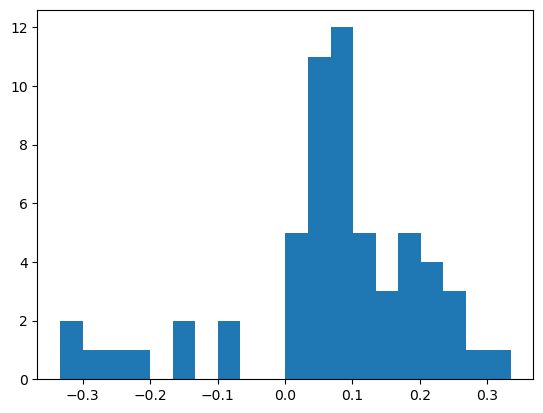

In [60]:
fig, ax = plt.subplots(1)

plt.hist(clusters_df_subclusters['TM_score_change_after_clustering'], bins=20)


In [ ]:
#At this stage, Oliver used Nir's clusters and did his calculations.  He removed any clusters that had no S. cerevisiae structure as a reference. That was 25 OGs so he ended up with 


In [84]:
## I removed any sequences that were less than 80% of the median length of the cluster

#clusters_df = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/clusters_0.15.csv'), index_col=0)
#assemble dictionary of OG_cluster to list of proteins

cluster_msa_base = aln_dir + os.sep + os.path.normpath('fasta') + os.sep

clusters = {}
clusters_ref = {}
clusters_len_norm = {}
clusters_len_filt = {}
len_filt_ratio = 0.8  #If sequences are less than 0.8 of the median length, filter them out.  
filtered_seqs = {}

for OG, clust in zip(clusters_df_C0_filt['ortho_group'], clusters_df_C0_filt['cluster']): 
    cluster_seqs = SeqIO.parse(cluster_msa_base + OG + clust + '.fa', 'fasta')
    seq_list = []
    N_refs = 0
    cluster_len = []
    for record in cluster_seqs: 
        short_seq = dyt.seq_squeeze(str(record.seq),all_outputs=False)
        cluster_len.append(len(short_seq))
        
        seq_list.append(record.id)
        if len(record.description.split('*'))==2: #The line with the * is assigned by tm_align as the reference for the alignment
            clusters_ref[OG + '_' + clust] = record.id
            N_refs = N_refs+1
    clusters[OG + '_' + clust] = seq_list
    
    cluster_len_array = np.array(cluster_len)
    med_len = np.median(cluster_len_array)
    clusters_len_norm[OG + '_' + clust] = (med_len, cluster_len_array/med_len)
    
    
    filtered_seqs[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]<len_filt_ratio)])
    
    clusters_len_filt[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]>len_filt_ratio)])
    
    if clusters_ref[OG + '_' + clust] in filtered_seqs[OG + '_' + clust]:
        clusters_ref[OG+'_' + clust] = clusters_len_filt[OG+'_'+clust][0]
        print('Reference sequence removed from ' + OG + '_' + clust + ' because it was too short. Replaced ref with first remaining sequence.')
    
    assert N_refs==1, 'More than one reference cluster ' + OG + '_' + clust

N_removed = 0

with open(aln_dir + os.sep + os.path.normpath('clustering/len_filtered_seqs.txt'), 'w') as f_out: 
    f_out.write('# Sequences filtered out because the sequence was less than ' + str(len_filt_ratio) + ' of the median length in the cluster \n')
    for og_clust, filtered_seq_list in filtered_seqs.items():
        N_removed = N_removed + len(filtered_seq_list)
        f_out.write('>' + og_clust + '\n')
        for filtered_seq in filtered_seq_list: 
            f_out.write(filtered_seq + '\n')

print(str(N_removed) + ' sequences removed because they were less than ' + str(len_filt_ratio) + ' of the median sequence length in their cluster')


Reference sequence removed from OG1819_C2 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG2290_C1 because it was too short. Replaced ref with first remaining sequence.
135 sequences removed because they were less than 0.8 of the median sequence length in their cluster


In [93]:
len(clusters_len_filt)

454

Text(0, 0.5, 'count')

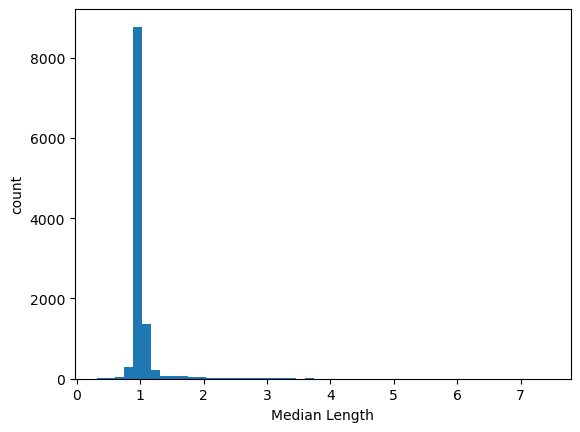

In [85]:
norm_lengths = []
for alignment, (med,norm_lengths_og) in clusters_len_norm.items():
    for norm_length in norm_lengths_og:
        norm_lengths.append(norm_length)

fig, ax = plt.subplots()
ax.hist(norm_lengths, bins=50)
ax.set_xlabel('Median Length')
ax.set_ylabel('count')

There are 454 nonzero clusters


Text(0, 0.5, 'N clusters')

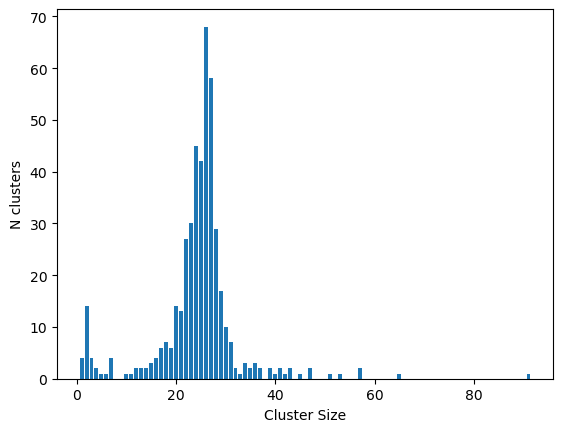

In [86]:
clust_lengths = []

min_clust_size = 4

#File to list small clusters (less than min_clust_size proteins) that are filtered out
small_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/small_clusters.txt')

#File to list clusters with no SC proteins
sc_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/non_sc_clusters.txt')


with(open(small_cluster_filt_fname, 'w')) as f_small:
    with(open(sc_cluster_filt_fname, 'w')) as f_no_sc:
        f_small.write('OG_cluster\tcluster_genes\n')
        f_no_sc.write('OG_cluster\tcluster_size\n')
        for og_clust, cluster in clusters_len_filt.items():
            no_sc_clust = True
            clust_len = len(cluster)
            clust_lengths.append(clust_len)
            if clust_len>0: 

                if clust_len<min_clust_size: 
                    f_small.write(og_clust+'\t[' + ",".join(cluster) + ']\n' )

                for seq in cluster: 
                    if seq.split('_')[0]=='REF':  #This means there is an S.cer protein present
                        no_sc_clust = False

                if no_sc_clust: 
                    f_no_sc.write(og_clust + '\t' + str(clust_len) + '\n')
                
            
clust_count = Counter(clust_lengths)

print('There are ' + str(len(clusters) - clust_count[0]) + ' nonzero clusters')

sizes = []
nclusts = []
for size, nclust in clust_count.items(): 
    if size>0:
        sizes.append(size)
        nclusts.append(nclust)

#Plot Histogram of all nonzero clusters
fig, ax = plt.subplots()

ax.bar(sizes, nclusts)
ax.set_xlabel('Cluster Size')
ax.set_ylabel('N clusters')



In [90]:
#List of clusters that don't have an SC protein but have more than a few proteins present.  
no_sc_clusters = pd.read_table(sc_cluster_filt_fname)
no_sc_clusters_filt = no_sc_clusters[no_sc_clusters['cluster_size']>3].sort_values(by='cluster_size', ascending=False)

# #'OG5006_C1' is strange - 5 different proteins from K.mar.  The S. cer orthoglog is COB, a mitochondrial encoded Cytochrome B Oxidase, as well as an overlapping transcript, BI3 which is a Maturase which mediates splicing of an intron.  
# # OG4755_C1 also has many K.mar genes and is COX2
# # OG5438 is ortholog of BIO3 (biotin synthesis)
# # OG5722 is ADH4 and has duplicates in a. hylecoeti

In [91]:
no_sc_clusters_filt

,OG_cluster,cluster_size
18,OG2290_C2,21
16,OG2228_C3,7
17,OG2228_C2,7
1,OG1111_C1,6
20,OG2357_C1,5
2,OG1168_C1,4
10,OG1810_C1,4


In [109]:
#Make a file to list all the clusters.  Also assigns first reference structure in a cluster as the representative (so we don't have redundant clusters)
#If there is no S. cer protein present it picks the tm_align assigned reference structure (which had a *) for the name - see clusters_ref
cluster_name_map = {}
with open(aln_dir + os.sep + ('clustering/cluster_mapping.csv'), 'w') as f_out: 
    f_out.write('primary_id,og_clust,cluster_rep,no_sc\n')
    for og_clust, cluster in clusters_len_filt.items():
        if len(cluster)>=min_clust_size:
            og, clust = og_clust.split('_')
            if og_clust in set(no_sc_clusters_filt['OG_cluster']):  #For clusters with no S. cer reference ##Use line with star as a reference
                seq = clusters_ref[og_clust]
                cluster_name_map[seq]=og_clust
                ref = seq.split('.')[0]
                f_out.write(og+ '_' + ref + ',' + og_clust + ',1,TRUE\n')
            else: #For clusters that have an S.cer reference
                cluster_rep = 1
                for seq in cluster: #lists same cluster multiple times if there are multiple S.cer refs present
                    if seq.split('_')[0]=='REF':
                        cluster_name_map[seq] = og_clust 
                        ref = seq.split('.')[0]
                        f_out.write(og+ '_' + ref + ',' + og_clust + ',' + str(cluster_rep) + ',FALSE\n')
                        cluster_rep = 0

In [8]:
#Make a dictionary that maps Nir's clusters to the representative cluster
cluster_mapping = pd.read_csv(aln_dir + os.sep + ('clustering/cluster_mapping.csv'))

cluster_mapping_reps = cluster_mapping[cluster_mapping['cluster_rep']==1]

cluster_mapping_reps.to_csv(aln_dir + os.sep + ('clustering/cluster_mapping_reps.csv'))

#This may only work for ben's og_refs = Oliver's are a bit different
og_ref_lookup_by_cluster = dict(zip(cluster_mapping_reps['og_clust'], cluster_mapping_reps['primary_id']))
og_ref_lookup_by_cluster

{'OG1004_C1': 'OG1004_REF_Scer_AF-P15938-F1-model_v2',
 'OG1004_C2': 'OG1004_REF_Scer_AF-P40459-F1-model_v2',
 'OG1012_C1': 'OG1012_REF_Scer_AF-P08004-F1-model_v2',
 'OG1016_C1': 'OG1016_REF_Scer_AF-P00330-F1-model_v2',
 'OG1021_C1': 'OG1021_REF_Scer_AF-P40047-F1-model_v2',
 'OG1022_C2': 'OG1022_REF_Scer_AF-P38715-F1-model_v2',
 'OG1022_C1': 'OG1022_REF_Scer_AF-P49954-F1-model_v2',
 'OG1030_C1': 'OG1030_REF_Scer_AF-P37291-F1-model_v2',
 'OG1032_C1': 'OG1032_REF_Scer_AF-P03965-F1-model_v2',
 'OG1039_C1': 'OG1039_REF_Scer_AF-P19414-F1-model_v2',
 'OG1052_C1': 'OG1052_REF_Scer_AF-P07245-F1-model_v2',
 'OG1054_C1': 'OG1054_REF_Scer_AF-P16861-F1-model_v2',
 'OG1055_C1': 'OG1055_REF_Scer_AF-P52910-F1-model_v2',
 'OG1056_C1': 'OG1056_REF_Scer_AF-P21954-F1-model_v2',
 'OG1060_C1': 'OG1060_REF_Scer_AF-P06169-F1-model_v2',
 'OG1070_C1': 'OG1070_REF_Scer_AF-P21524-F1-model_v2',
 'OG1081_C1': 'OG1081_REF_Scer_AF-P32784-F1-model_v2',
 'OG1087_C1': 'OG1087_REF_Scer_AF-P39518-F1-model_v2',
 'OG1096_C

In [5]:
cluster_mapping

,primary_id,og_clust,cluster_rep,no_sc
0,OG1004_REF_Scer_AF-P15938-F1-model_v2,OG1004_C1,1,False
1,OG1004_REF_Scer_AF-P20095-F1-model_v2,OG1004_C1,0,False
2,OG1004_REF_Scer_AF-P24384-F1-model_v2,OG1004_C1,0,False
3,OG1004_REF_Scer_AF-P53131-F1-model_v2,OG1004_C1,0,False
4,OG1004_REF_Scer_AF-P40459-F1-model_v2,OG1004_C2,1,False
...,...,...,...,...
525,OG5327_REF_Scer_AF-P43635-F1-model_v2,OG5327_C1,1,False
526,OG5404_REF_Scer_AF-P06115-F1-model_v2,OG5404_C1,1,False
527,OG5441_REF_Scer_AF-P00724-F1-model_v2,OG5441_C1,1,False
528,OG5490_REF_Scer_AF-P32340-F1-model_v2,OG5490_C1,1,False


In [99]:
small_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/small_clusters.txt')
small_clusters = pd.read_table(small_cluster_filt_fname)

#Small clusters that are not in the difference between clusters filtered out by length?
set(small_clusters['OG_cluster']) - (set(clusters_len_filt.keys()) - set(cluster_name_map.values()))

#{'OG1060_C2', 'OG1603_C2', 'OG1714_C1'}

In [40]:
#Rename the TM-align structural alignments to match our orignal filenames. 
#Filter out
#  OGs that had too few sequences
#  peptide sequences that were too short

#pep_seq_dir = base_dir + os.sep + os.path.normpath('og_sequences/proteome')

clust_align_dir = aln_dir + os.sep + 'fasta' + os.sep
clust_align_rename_dir = aln_dir + os.sep + 'fasta_renamed' + os.sep
#clust_align_rename_all_dir = tm_align_dir + os.sep + 'fasta_renamed_all' + os.sep

cluster_mapping = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/cluster_mapping.csv'))
cluster_mapping_dict = dict(zip(cluster_mapping['primary_id'], cluster_mapping['og_clust']))


#Option 1:  File only for representative clusters: 
for (ind, (og_ref,og_clust, cluster_rep, no_sc)) in cluster_mapping.iterrows():
    if cluster_rep == 1: 
        if not(og_clust in set(small_clusters['OG_cluster'])):
            og, clust = og_clust.split('_')
            
            full_cluster_in_fname =  clust_align_dir + og+clust + '.fa'
            
            full_cluster_in = SeqIO.parse(full_cluster_in_fname, 'fasta')
            
            clust_list = clusters_len_filt[og_clust]
            
            with open(clust_align_rename_dir+og_ref + '.tm.fasta', 'w') as f_out: 
                for record in full_cluster_in: 
                    if record.id in clust_list: 
                        f_out.write('>' + record.description + '\n')
                        f_out.write(str(record.seq) + '\n')
                        
# #Option 2: File for every cluster that is present in the main data set (and some are redundant)
# for prot_fname in os.listdir(pep_seq_dir):
#     og_ref = prot_fname.split('.')[0]
#     clust = cluster_mapping_dict[og_ref]
#     og, clust = clust.split('_')
#     shutil.copyfile(clust_align_dir + og+clust + '.fa', clust_align_rename_all_dir + og_ref + '.tm.fasta')



In [21]:
#Count Fasta Renamed Files
clust_align_rename_dir = aln_dir + os.sep + 'fasta_renamed' + os.sep

cluster_mapping = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/cluster_mapping.csv'))
cluster_mapping_dict = dict(zip(cluster_mapping['primary_id'], cluster_mapping['og_clust']))
og_ref_list = os.listdir(clust_align_rename_dir)

set([og_ref.split('.')[0] for og_ref in og_ref_list]) - set(cluster_mapping[cluster_mapping['cluster_rep']==1]['primary_id'])

#There were 440 Fasta Renamed files, but that included these which failed the initial spec filter, so should not have been included.  

{'OG4755_kluyveromyces_marxianus__OG4755__51_759',
 'OG5438_kluyveromyces_marxianus__OG5438__51_4321',
 'OG5722_geotrichum_candidum__OG5722__43_1771',
 'OG6065_kluyveromyces_marxianus__OG6065__51_1934',
 'OG6290_vanderwaltozyma_polyspora__OG6290__136_4191',
 'OG6574_kluyveromyces_marxianus__OG6574__51_629',
 'OG6598_kluyveromyces_marxianus__OG6598__51_2377',
 'OG7278_kazachstania_naganishii__OG7278__49_2415'}

In [8]:
spec_filter_fail

{'OG4755',
 'OG5006',
 'OG5314',
 'OG5438',
 'OG5722',
 'OG6065',
 'OG6290',
 'OG6574',
 'OG6598',
 'OG7278',
 'OG7818'}

In [42]:
#Build a file with each proteome sequence and coding sequence for each item in the MSA

#Make big dictionary for selected coding sequences 
cds_dir = base_dir + os.sep + os.path.normpath('selected_proteins/cds') + os.sep

selected_cds_seqs = {}

for cds_file in os.listdir(cds_dir):
    cds_fasta = SeqIO.parse(cds_dir + cds_file, 'fasta')
    for record in cds_fasta: 
        selected_cds_seqs[record.id] = str(record.seq)

#Iterate through each msa 
clust_align_rename_dir = aln_dir + os.sep + 'fasta_renamed' + os.sep

seq_dir = base_dir + os.sep + 'selected_proteins' + os.sep +  'og_sequences'

for msa_file in os.listdir(clust_align_rename_dir):
    cds_file_out = seq_dir + os.sep + 'cds_tm_5' + os.sep + msa_file.split('.')[0] + '.cds.fasta'
    pep_file_out = seq_dir + os.sep + 'proteome_tm_5' + os.sep + msa_file.split('.')[0] + '.pep.fasta'
    
    msa_file_fasta = SeqIO.parse(clust_align_rename_dir + msa_file, 'fasta')
    
    with open(cds_file_out,'w') as f_out_cds: 
        with open(pep_file_out,'w') as f_out_pep:
            for record in msa_file_fasta: 
                 #Squeeze out dashes and record protein sequences
                pep_seq = ''.join([res for res in record.seq if res !='-'])
                f_out_pep.write('>' + record.id + '\n')
                f_out_pep.write(pep_seq + '\n') 
                
                #Write CDS sequences
                try:
                    f_out_cds.write('>' + record.id + '\n')
                    f_out_cds.write(selected_cds_seqs[record.id.split('.')[0]] + '\n') #Remove .pdb from name
                except KeyError:
                    print(record.id +  ' cds not found for ' + msa_file)

In [ ]:
## Thread alignments inside inside singularity container
#call_code_singularity.sh
#which calls /home/heineike_wsl2/github_s/diverse_yeast/20221206_struct_align_dnds_msa.sh
#which calls /home/heineike_wsl2/github_s/diverse_yeast/20221206_struct_align_dnds_msa.py

In [ ]:
###Sequence MSAs - also describe structural MSAs


In [29]:
## Original code in case we want to go back and do it for Oliver's alignments

# #Build a big dictionary for selected coding sequences and make a file for each og_ref name with corresponding cds

# #Make a dictionary of coding sequences
# cds_dir = base_dir + os.sep + os.path.normpath('selected_proteins/cds') + os.sep

# selected_cds_seqs = {}

# for cds_file in os.listdir(cds_dir):
#     cds_fasta = SeqIO.parse(cds_dir + cds_file, 'fasta')
#     for record in cds_fasta: 
#         selected_cds_seqs[record.id] = str(record.seq)

# #Iterate through each msa and make a codon sequence fasta (unaligned)

# seq_dir = base_dir + os.sep + 'og_sequences'

# for protein_file in os.listdir(seq_dir + os.sep + 'proteome' ):
#     cds_file_out = seq_dir + os.sep + 'cds' + os.sep + protein_file.split('.')[0] + '.cds.fasta'
    
#     protein_file_full = seq_dir + os.sep+ 'proteome' + os.sep + protein_file    
#     protein_file_fasta = SeqIO.parse(protein_file_full, 'fasta')
    
#     with open(cds_file_out,'w') as f_out_cds: 
#         for record in protein_file_fasta: 
#             try:
#                 f_out_cds.write('>' + record.id + '\n')
#                 f_out_cds.write(selected_cds_seqs[record.id] + '\n') 
#             except KeyError:
#                 print(record.id +  'cds not found for ' + protein_file)

In [30]:
##This is improved above
# #Make corresponding codon alignments. 

# #First make cds lists that contain the same sequences as the clusters
# tm_align_dir = base_dir + os.sep +  os.path.normpath('msas/structural/tm_align')
# clust_align_rename_dir = tm_align_dir + os.sep + 'fasta_renamed' + os.sep
# cds_seq_dir = base_dir + os.sep + os.path.normpath('og_sequences/cds') + os.sep
# cds_seq_dir_out = tm_align_dir + os.sep + 'cds' + os.sep



# for tm_align_fname in os.listdir(clust_align_rename_dir): 
#     tm_align = SeqIO.parse(clust_align_rename_dir + tm_align_fname, 'fasta')
#     og_ref_base = tm_align_fname.split('.')[0] 
#     cds_seq_fname = cds_seq_dir + og_ref_base + '.cds.fasta'
#     cds_seq = SeqIO.parse(cds_seq_fname, 'fasta')
#     cds_seq_lookup = {}
#     for record_cds in cds_seq: 
#         cds_seq_lookup[record_cds.id] = str(record_cds.seq)
    
#     cds_seq_fname_out = cds_seq_dir_out + og_ref_base + '.tm_present.cds.fasta'
#     with open(cds_seq_fname_out, 'w') as f_out:
#         for record in tm_align: 
#             record_id = record.id.split('.')[0]
#             try: 
#                 f_out.write('>' + record_id + '\n')
#                 f_out.write(cds_seq_lookup[record_id] + '\n')
#             except KeyError:
#                 print('No cds file for ' + record_id + ' in ' + tm_align_fname)

## Visualize phylogenetic trees of orthogroups that are broken apart by clustering with cluster colored in

In [2]:
#Build trees from original orthogroup sequences

clusters_df_subclusters = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/subclustered_structural_orthogroups.csv'))
#Gather original orthogroup sequence lists for clusters that get broken apart into a folder. 

#Note:  To do this we would need all the PDB files for the subclustered sequences.  



In [13]:
# For example orthogroup (1022) make tree with original sequences from PDB, using multiple alignment from US-align.  Would be best to make the multiple alignment using structures but for now will make with sequences.  

#Make list for US align alignment
pdb_dir = base_dir + os.sep + os.path.normpath('selected_proteins/pdbs/OG1022')

pdb_list_fname = pdb_dir + os.sep + 'pdb_list.txt'  

with open(pdb_list_fname,'w') as f_out: 
    for fname in os.listdir(pdb_dir):
        if fname.split('.')[1]=='pdb':
            f_out.write(fname.split('.')[0] +'\n' ) 


In [2]:
#Use USalign to make an MSA in 20240215_usalign_example_og.sh

In [31]:
#Extract the MSA and put it into a fasta

usalign_msa_fname = pdb_dir + os.sep + 'us_align.fasta'
usalign_msa_clean_fname = pdb_dir + os.sep + 'us_align_clean.fasta'
with open(usalign_msa_fname,'r') as f_in: 
    with open(usalign_msa_clean_fname, 'w') as f_out: 
        for line in f_in:
            if line[0]=='>': 
                seqname_only = line.strip('>').split('.')[0]
                f_out.write('>'+seqname_only + '\n')
                f_out.write(next(f_in))


In [14]:
# #Test PDB parsing 

# pdb_fname = base_dir + os.sep + os.path.normpath('selected_proteins\pdbs\Alphafold_Scer_sel\AF-P0CF18-F1-model_v2.pdb')

# for record in SeqIO.parse(pdb_fname, "pdb-seqres"):
#     print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
#     print(record.seq)


In [ ]:

# cluster_mapping = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/cluster_mapping.csv'))
# cluster_mapping_reps = cluster_mapping[cluster_mapping['cluster_rep']==1]

# cluster_mapping_reps_dict = dict(zip(cluster_mapping_reps['og_clust'],cluster_mapping_reps['primary_id']))

In [3]:
#Gather original orthogroup sequence lists for clusters that get broken apart into a folder. 

#Trim sequences and run iqtree. 

#Run through singularity using call_code_singularity_bens_cpu.sh from Ben's computer which calls 20240215_full_og_tree.sh and points to 20240215_full_og_tree.py



In [3]:
#tree_dir = pdb_dir + base_dir + os.sep + 'msas' + os.sep + 'ogs_pep_trees'

og = 'OG1022'

cluster_colors = {'C1': 'red', 
                  'C2': 'LightSteelBlue',
                  'C3': 'magenta'
                 }


subcluster_contents_fname = aln_dir + os.sep + os.path.normpath('clustering/cluster_sequence_list_initial.json')

with open(subcluster_contents_fname, 'r') as f:
    subcluster_contents = json.load(f)


fname_tree = base_dir + os.sep + os.path.normpath('selected_proteins/pdbs/' + og + '/tree/us_align_trimmed.fasta.clipkit.treefile')
t = Tree(fname_tree, format=1)   # format=1 allows it to work with the bootstrap values 
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = True
                                                  
clusters_df_subclusters_og = clusters_df_subclusters.groupby('ortho_group').get_group(og)
cluster_ids = clusters_df_subclusters_og['cluster'] 
                                            
# nodes = {}

# for cluster_id in cluster_ids: 
#     nodes[cluster_id] = NodeStyle()
#     nodes[cluster_id]['bgcolor'] = cluster_colors[cluster_id]

for node in t.traverse(): 
    if node.is_leaf():
        name = node.name
        
        spec, gene_id = dyt.species_from_fasta_id(node.name)
        
        new_name = spec + '__' + gene_id  # + '__' + y1000_id
        
        node_color = 'white'
        
        for cluster_id  in cluster_ids: 
            subcluster_contents_list = [name.split('.')[0] for name in subcluster_contents[og + '_' + cluster_id]]
            if name in subcluster_contents_list:
                node_color = cluster_colors[cluster_id]
                
        ns = NodeStyle()
        ns['bgcolor'] = node_color
        #else: 
        #    ns['bgcolor'] = 'white'

        node.set_style(ns)
        node.name = new_name
            #node.set_style(nodes[cluster_id])
#             elif new_name in cluster_names_og['C2']: 
#                 node.set_style(red_node)

#             node.name = new_name
        name_face = AttrFace("name",fsize=20)
        node.add_face(name_face, column=0, position="branch-right") 
        
t.ladderize()
#t.render('%%inline', tree_style=ts)
t.render( base_dir + os.sep + os.path.normpath('selected_proteins/pdbs/' + og + '/tree/tree_image.svg'), tree_style=ts)

{'nodes': [[7.5, 103.50007952749729, 11.5, 107.50007952749729, 0, None],
  [49.5, 19.0, 53.5, 23.0, 1, None],
  [49.5, 59.0, 53.5, 63.0, 2, None],
  [42.5, 188.00015905499458, 46.5, 192.00015905499458, 3, None],
  [77.5, 119.0, 81.5, 123.0, 4, None],
  [112.5, 99.0, 116.5, 103.0, 5, None],
  [105.5, 139.0, 109.5, 143.0, 6, None],
  [77.5, 257.00031810998917, 81.5, 261.00031810998917, 7, None],
  [112.5, 179.0, 116.5, 183.0, 8, None],
  [112.5, 335.00063621997833, 116.5, 339.00063621997833, 9, None],
  [147.5, 219.0, 151.5, 223.0, 10, None],
  [147.5, 451.00127243995667, 151.5, 455.00127243995667, 11, None],
  [189.5, 296.5, 193.5, 300.5, 12, None],
  [224.5, 259.0, 228.5, 263.0, 13, None],
  [224.5, 334.0, 228.5, 338.0, 14, None],
  [259.5, 299.0, 263.5, 303.0, 15, None],
  [259.5, 369.0, 263.5, 373.0, 16, None],
  [294.5, 339.0, 298.5, 343.0, 17, None],
  [294.5, 399.0, 298.5, 403.0, 18, None],
  [329.5, 379.0, 333.5, 383.0, 19, None],
  [329.5, 419.0, 333.5, 423.0, 20, None],
  [175.

In [33]:
fasta_id = 'kazachstania_naganishii__OG1022__49_729'

fasta_id_sp = fasta_id.split('_')
if fasta_id_sp[0] in ['REF','Scer','Calb','Spom']:
    if fasta_id_sp[0] == 'REF':
        if fasta_id_sp[1] in ['Scer','Calb','Spom']: 
            spec = dyt.model_spec_lookup[fasta_id_sp[1]]
            prot_id = fasta_id_sp[2].split('-')[1]
        else:   
            # ref is not Scer, Calb, Spom
            print('REF seq is not Scer, Calb or Spom')
            spec = '_'.join(fasta_id.split('__')[0].split('_')[1:3])
            prot_id = fasta_id.split('__')[2]
    else:
        spec = dyt.model_spec_lookup[fasta_id_sp[0]]
        prot_id = fasta_id_sp[1].split('-')[1]
else: 
    spec = fasta_id.split('__')[0]
    prot_id = fasta_id.split('__')[2]

In [37]:
fasta_id = 'kazachstania_naganishii__OG1022__49_729'

In [38]:
dyt.species_from_fasta_id(fasta_id)

('kazachstania_naganishii', '49_729')

In [52]:
for og, subclusters in clusters_df_subclusters.groupby('ortho_group'):
    a = subclusters

In [122]:
#Visualize phylogenetic trees of orthogroups that are broken apart by clustering with cluster colored in

species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
species_table_short = species_table.loc[species_table['Load']=='Y', ['original_genome_id', 'jacobs_name']]
spec_time_tree_2_orig = dict(zip(species_table_short['jacobs_name'], species_table_short['original_genome_id']))

out_image_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/cluster_trees')+ os.sep


# ogs_w_subclusters = []
# for og_clust in list(set(cluster_mapping['og_clust'])): 
#     og, clust = og_clust.split('_')
#     if clust=='C2': 
#         ogs_w_subclusters.append(og)


# for og, subclusters in clusters_df_subclusters.groupby('ortho_group'):
#     for cluster in subclusters['cluster']: 
        
        
        
    
#     cluster_names_og = {}

#     for cluster in ['C1','C2']: 
#         cluster_names_og[cluster] = [clust_name.split('.')[0] for clust_name in clusters[og+'_' + cluster]]

#     tree_dir = base_dir + os.sep + 'msas' + os.sep + 'ogs_pep_trees'
#     fname_tree = tree_dir + os.sep + og + '.mfaa.mafft.clipkit.treefile'
#     t = Tree(fname_tree, format=0)  
#     ts = TreeStyle()
#     ts.show_leaf_name = False
#     ts.show_branch_length = True

#     red_node = NodeStyle()
#     red_node['bgcolor'] = 'red'

#     blue_node = NodeStyle()
#     blue_node['bgcolor']= 'LightSteelBlue'


#     for node in t.traverse(): 
#         if node.is_leaf():
#             (spec_time_tree, y1000_id) = node.name.split('|')
#             spec_orig = spec_time_tree_2_orig[spec_time_tree]
#             if spec_orig in ['saccharomyces_cerevisiae', 'candida_albicans', 'schizosaccaromyces_pombe']:  #probably none in Pombe
#                 print(node.name)
#             else:
#                 new_name = spec_orig + '__' + og + '__' + y1000_id

#                 if new_name in cluster_names_og['C1']:
#                     node.set_style(blue_node)
#                 elif new_name in cluster_names_og['C2']: 
#                     node.set_style(red_node)

#                 node.name = new_name
#                 name_face = AttrFace("name",fsize=20)
#                 node.add_face(name_face, column=0, position="branch-right") 
#                 #convert name to primary id

#     t.ladderize()
#     #t.render('%%inline', tree_style=ts)
#     t.render(out_image_dir + og + '.pdf', tree_style=ts)

In [ ]:
No C2: 
1603
1060 

1168 - a lot missing

C1 clusters not together: 
1354, 1394, 1468, 1597, 2071, 2290, 2357 (interesting), 3030, 3104, 3151

5735 - how did this pass our filter - not very many sequences

## Nir spotted some orthogroups in which Pombe genes are shared in multiple orthogroups

OG1	OG2
Spom_AF-Q10142-F1-model_v2.pdb	OG1242	OG4624
Spom_AF-P55306-F1-model_v2.pdb	        OG1310	OG5404
Spom_AF-O14192-F1-model_v2.pdb	OG1377	OG3639
Spom_AF-Q09755-F1-model_v2.pdb	OG2032	OG4665
Spom_AF-Q09741-F1-model_v2.pdb	OG2508	OG3801
Spom_AF-O94413-F1-model_v2.pdb	OG2588	OG2968
Spom_AF-P33075-F1-model_v2.pdb	        OG2740	OG5118
Spom_AF-Q7LKX0-F1-model_v2.pdb	OG3021	OG3909
Spom_AF-O13917-F1-model_v2.pdb	OG4317	OG4398

Oliver sees it is in the og_metadata

OGs sharing same pathway (e.g. for the first three)
Spom_AF-Q10142-F1-model_v2.pdb	OG1242	OG4624		"['SPHINGOLIPID-SYN-PWY-1']"
Spom_AF-P55306-F1-model_v2.pdb	       OG1310	OG5404		"['DETOX1-PWY']"
Spom_AF-O14192-F1-model_v2.pdb	OG1377	OG3639 	"['ALL-CHORISMATE-PWY-1', 'COMPLETE-ARO-PWY-1', 'PWY3O-351', 'PWY3O-4108', 'PWY3O-4153']"


S.pombe Q10142 is https://www.uniprot.org/uniprotkb/Q10142/entry
AUR1 Ortholog of AUR1 in S.cer

OG124 is AUR1 in S.cer

OG4624 is IPT1 in S.cer which also looks like a distant ortholog to AUR1

http://eggnog5.embl.de/#/app/results?seqid=Q10142&target_nogs=ENOG502QPQM#ENOG5028HC7_datamenu






In [30]:
#Model species info

#C. albicans
#http://www.candidagenome.org/download/sequence/C_albicans_SC5314/Assembly22/current/  
# C_albicans_SC5314_A22_current_default_coding.fasta
# C_albicans_SC5314_A22_current_default_protein.fasta
#downloaded on 20221012 and stored in
#G:\My Drive\Crick_LMS\external_data\genomes\Candida_albicans


#S. cerevisiae
#G:\My Drive\Crick_LMS\external_data\genomes\Saccharomyces_cerevisiae\S288C_reference_genome_R64-2-1_20150113
#orf_coding_all_R64-2-1_20150113.fasta
#orf_trans_all_R64-2-1_20150113.fasta

#S. pombe
#From https://www.pombase.org/data/genome_sequence_and_features/feature_sequences/ on 20221012
#cds.fa 
#peptide.fa  
#both last modified 2022-10-12 03:26
#Stored at
#G:\My Drive\Crick_LMS\external_data\genomes\Schizosaccharomyces_pombe